In [2]:
# Reading in data and verify it is the same set as the book
OfflinePath1 = 'C:/Users/casey/Dropbox/SMU_DataScience/MSDS_7333_QuantifyingTheWorld/Homework/CaseStudy1/offline.final.trace.txt'
OfflinePath2 = "/home/kyle/Documents/thomaskh522@gmail.com/SMU/Quant the World/RTLS_CaseStudy/Data/offline_data.txt"

readData = 
  function(filename, 
           subMacs = c("00:0f:a3:39:e1:c0", "00:0f:a3:39:dd:cd", "00:14:bf:b1:97:8a",
                       "00:14:bf:3b:c7:c6", "00:14:bf:b1:97:90", "00:14:bf:b1:97:8d",
                       "00:14:bf:b1:97:81"))
  {
    txt = readLines(filename)
    lines = txt[ substr(txt, 1, 1) != "#" ]
    tmp = lapply(lines, processLine)
    offline = as.data.frame(do.call("rbind", tmp), 
                            stringsAsFactors= FALSE) 
    
    names(offline) = c("time", "scanMac", 
                       "posX", "posY", "posZ", "orientation", 
                       "mac", "signal", "channel", "type")
    
     # keep only signals from access points
    offline = offline[ offline$type == "3", ]
    submac = names(sort(table(offline$mac), decreasing = TRUE))[1:7]

    # drop scanMac, posZ, channel, and type - no info in them
    dropVars = c("scanMac", "posZ", "channel", "type")
    offline = offline[ , !( names(offline) %in% dropVars ) ]
    

    # drop more unwanted access points
    offline = offline[ offline$mac %in% subMacs, ]
    
    # convert numeric values
    numVars = c("time", "posX", "posY", "orientation", "signal")
    offline[ numVars ] = lapply(offline[ numVars ], as.numeric)

    offline$posX = round(offline$posX,0)
    offline$posY = round(offline$posY,0)
      
    offline$posXY = paste(offline$posX, offline$posY, sep = "-")
      
    # convert time to POSIX
    offline$rawTime = offline$time
    offline$time = offline$time/1000
    class(offline$time) = c("POSIXt", "POSIXct")
    
    # round orientations to nearest 45
    offline$angle = roundOrientation(offline$orientation)
      
    return(offline)
  }

processLine = function(x){
    tokens = strsplit(x, "[;=,]")[[1]]
    
    if (length(tokens) == 10)
        return(NULL)
    tmp = matrix(tokens[-(1:10)], ncol=4, byrow = TRUE)
    cbind(matrix(tokens[c(2,4,6:8,10)], nrow = nrow(tmp), ncol=6, byrow=TRUE), tmp)
}

roundOrientation = function(angles) {
    refs = seq(0, by = 45, length = 9)
    q = sapply(angles, function(o) which.min(abs(o-refs)))
    c(refs[1:8], 0)[q]
}
     
offline = readData(OfflinePath2)
# online = readData(OnlinePath1)

null device 
          1

null device 
          1

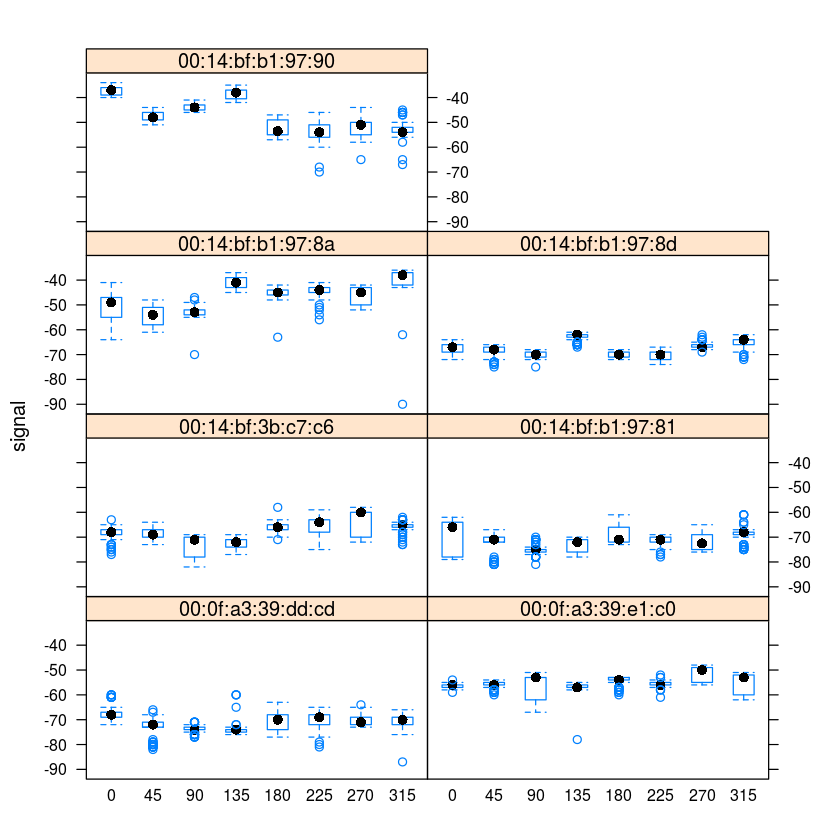

In [3]:
#pdf(file = "Geo_BoxplotSignalByMacAngle.pdf", width = 7)
oldPar = par(mar = c(3.1, 3, 1, 1))

library(lattice)
bwplot(signal ~ factor(angle) | mac, data = offline, 
       subset = posX == 2 & posY == 12, 
       layout = c(2,4))

par(oldPar)
dev.off()

# summary(offline$signal)

#pdf(file = "Geo_DensitySignalByMacAngle.pdf", width = 8, height = 12)
oldPar = par(mar = c(3.1, 3, 1, 1))

densityplot( ~ signal | mac + factor(angle), data = offline,
             subset = posX == 24 & posY == 4,
             bw = 0.5, plot.points = FALSE)

par(oldPar)
dev.off()

null device 
          1

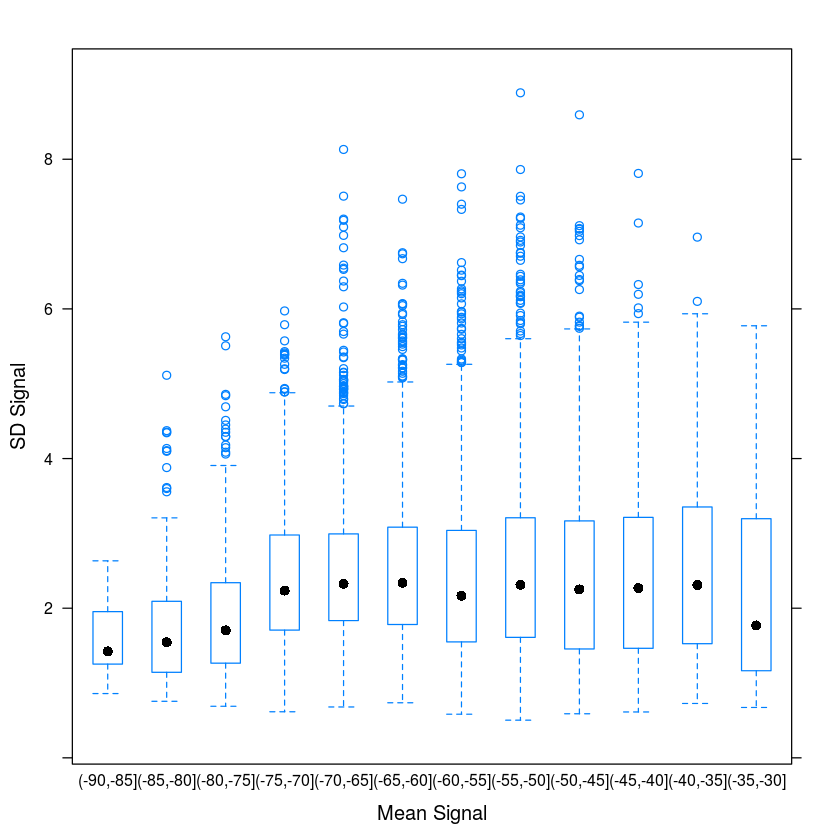

In [23]:
#offline = offline[ offline$mac != "00:0f:a3:39:dd:cd", ]

offline$posXY = paste(offline$posX, offline$posY, sep = "-")

byLocAngleAP = with(offline, 
                    by(offline, list(posXY, angle, mac), 
                       function(x) x))

signalSummary = 
  lapply(byLocAngleAP,            
         function(oneLoc) {
           ans = oneLoc[1, ]
           ans$medSignal = median(oneLoc$signal)
           ans$avgSignal = mean(oneLoc$signal)
           ans$num = length(oneLoc$signal)
           ans$sdSignal = sd(oneLoc$signal)
           ans$iqrSignal = IQR(oneLoc$signal)
           ans
           })

offlineSummary = do.call("rbind", signalSummary)  

#pdf(file = "Geo_BoxplotSignalSDByAvg.pdf", width = 10)
oldPar = par(mar = c(3.1, 3, 1, 1))

breaks = seq(-90, -30, by = 5)
bwplot(sdSignal ~ cut(avgSignal, breaks = breaks),
       data = offlineSummary,
       xlab = "Mean Signal", ylab = "SD Signal")

par(oldPar)
dev.off()

null device 
          1

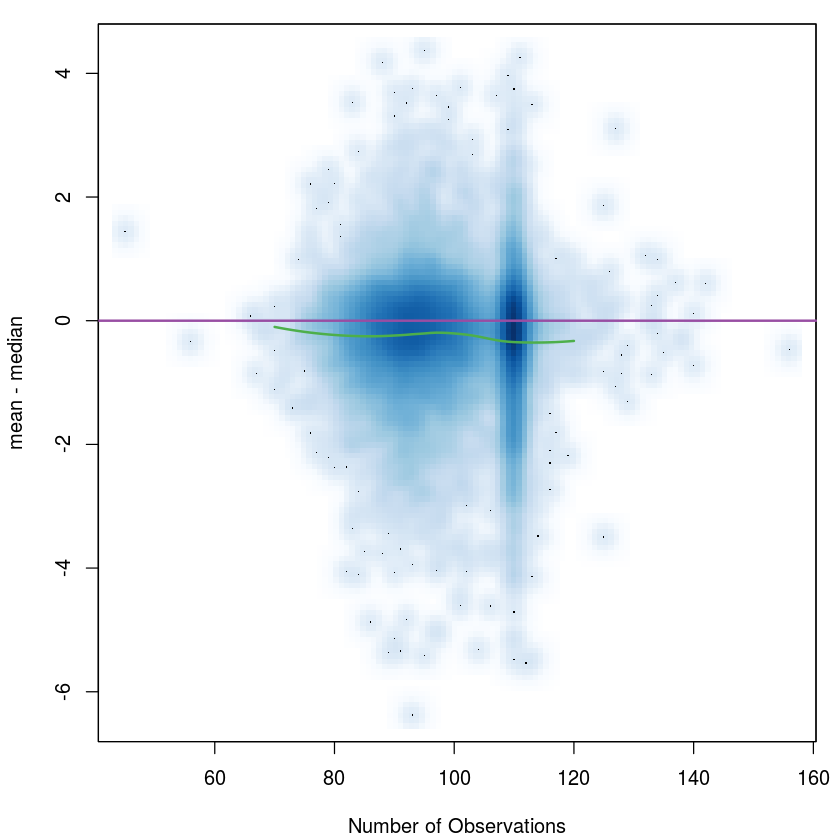

In [5]:
#pdf(file = "Geo_ScatterMean-Median.pdf", width = 10)
oldPar = par(mar = c(4.1, 4.1, 1, 1))
submac = names(sort(table(offline$mac), decreasing = TRUE))[1:7]

with(offlineSummary,
     smoothScatter((avgSignal - medSignal) ~ num,
                   xlab = "Number of Observations", 
                   ylab = "mean - median"))
abline(h = 0, col = "#984ea3", lwd = 2)

lo.obj = 
  with(offlineSummary,
       loess(diff ~ num, 
             data = data.frame(diff = (avgSignal - medSignal),
                               num = num)))

lo.obj.pr = predict(lo.obj, newdata = data.frame(num = (70:120)))
lines(x = 70:120, y = lo.obj.pr, col = "#4daf4a", lwd = 2)

par(oldPar)
dev.off()

[1] "00:14:bf:b1:97:81"
[1] "00:14:bf:b1:97:81"


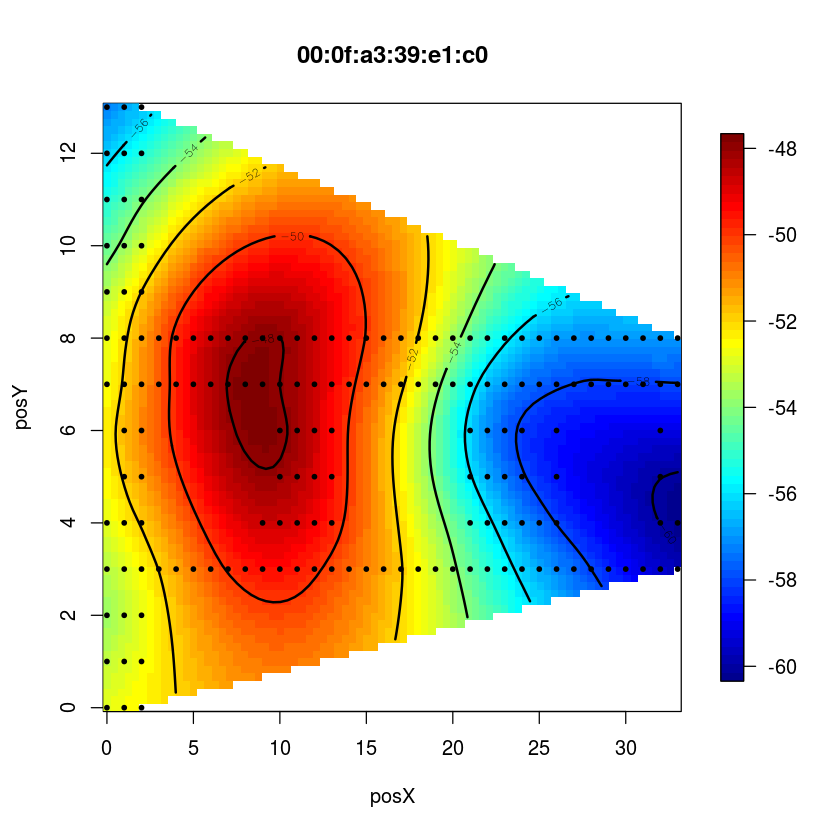

[1] "00:14:bf:b1:97:81"


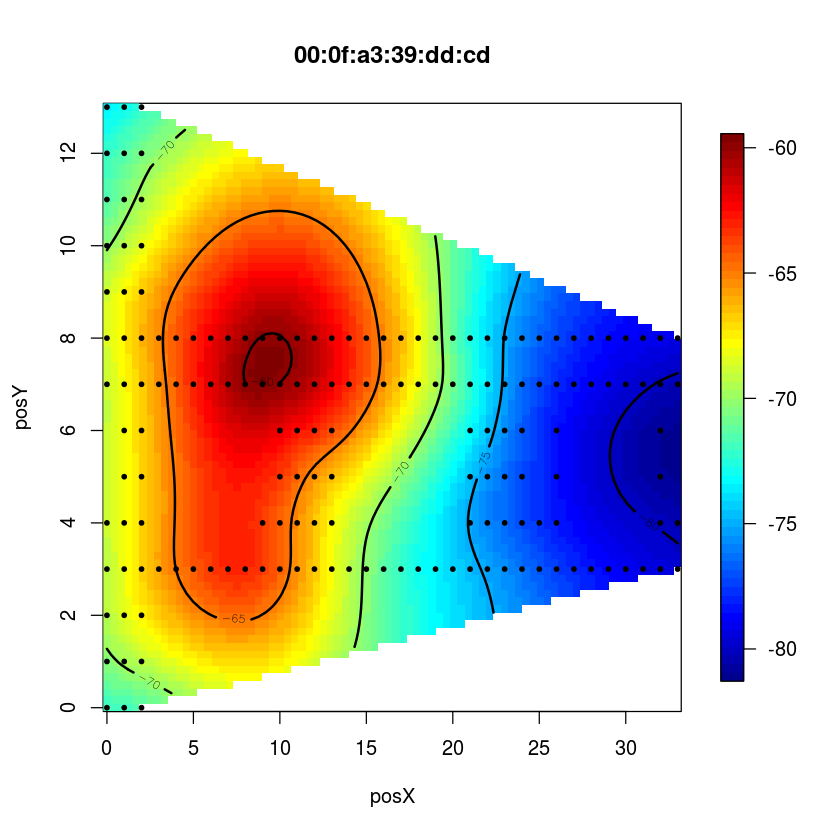

[1] "00:14:bf:b1:97:81"


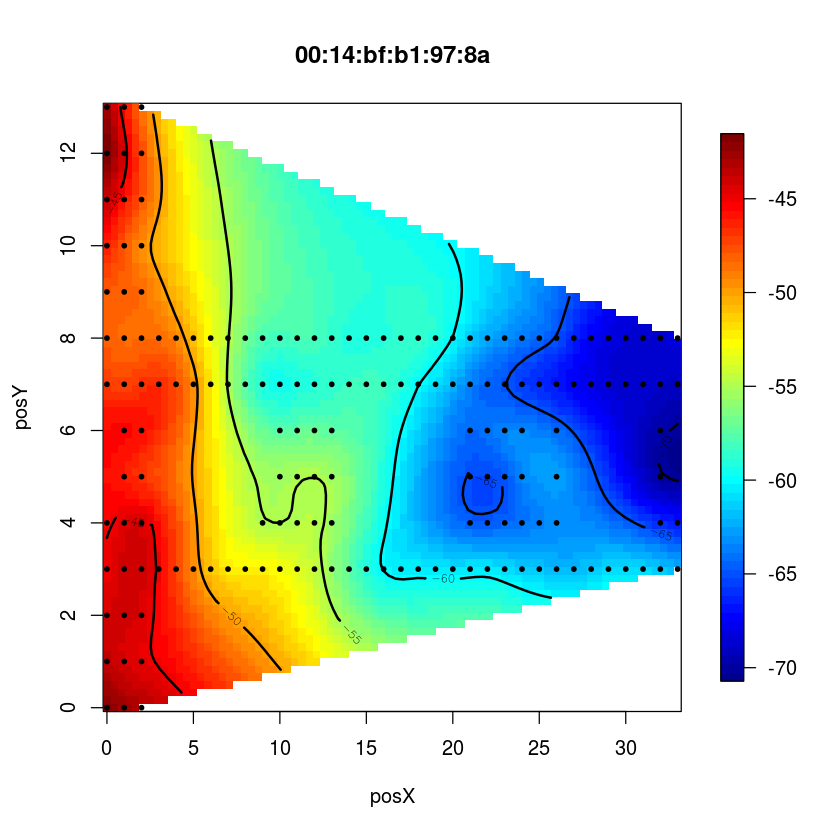

[1] "00:14:bf:b1:97:81"


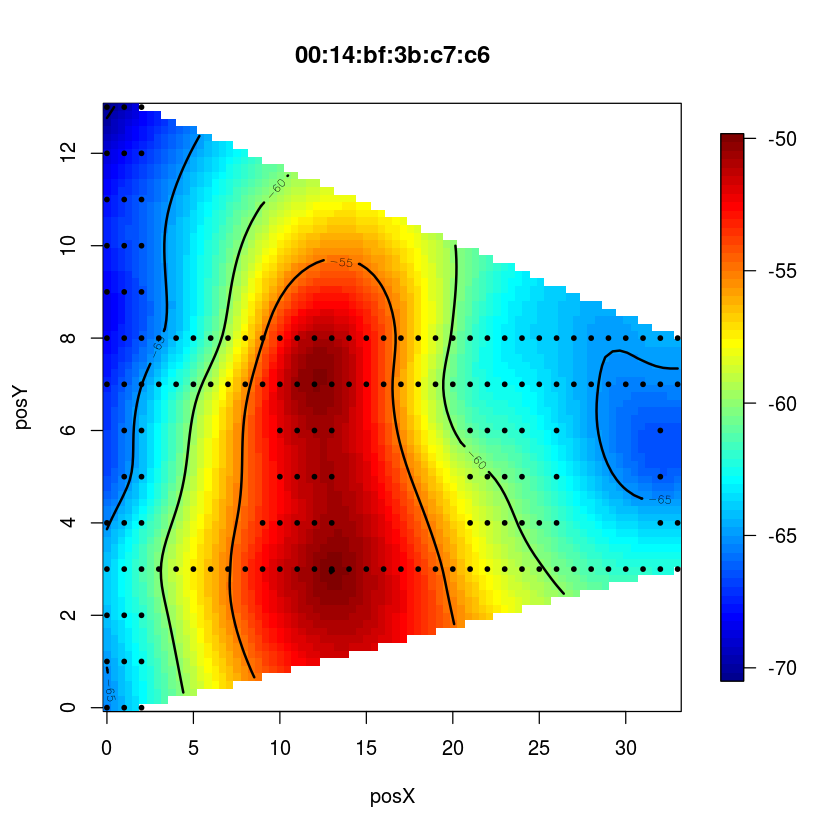

[1] "00:14:bf:b1:97:81"


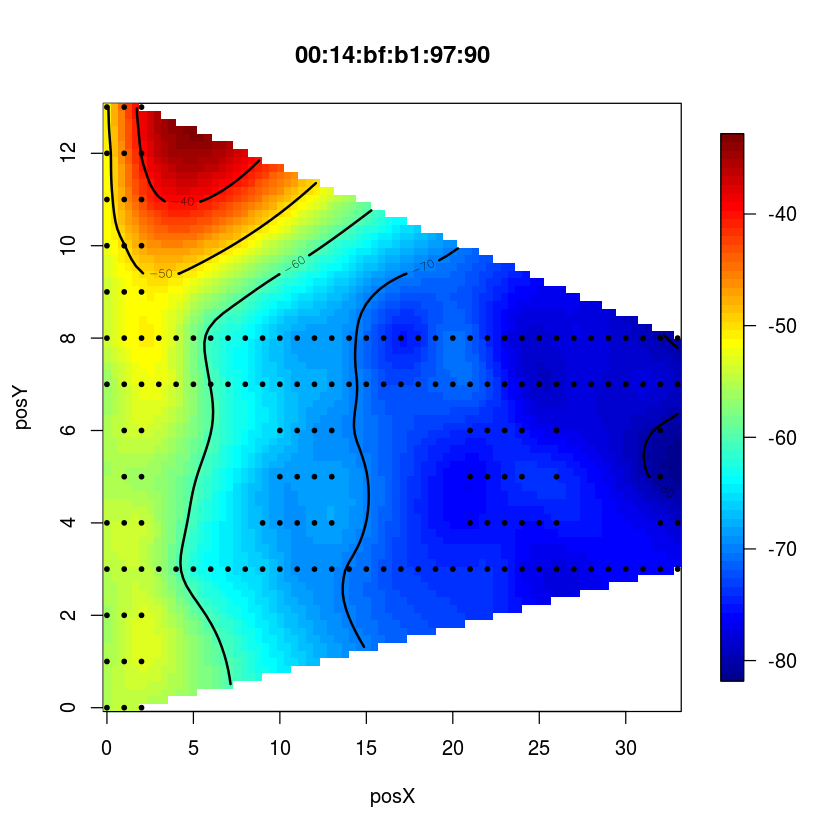

[1] "00:14:bf:b1:97:81"


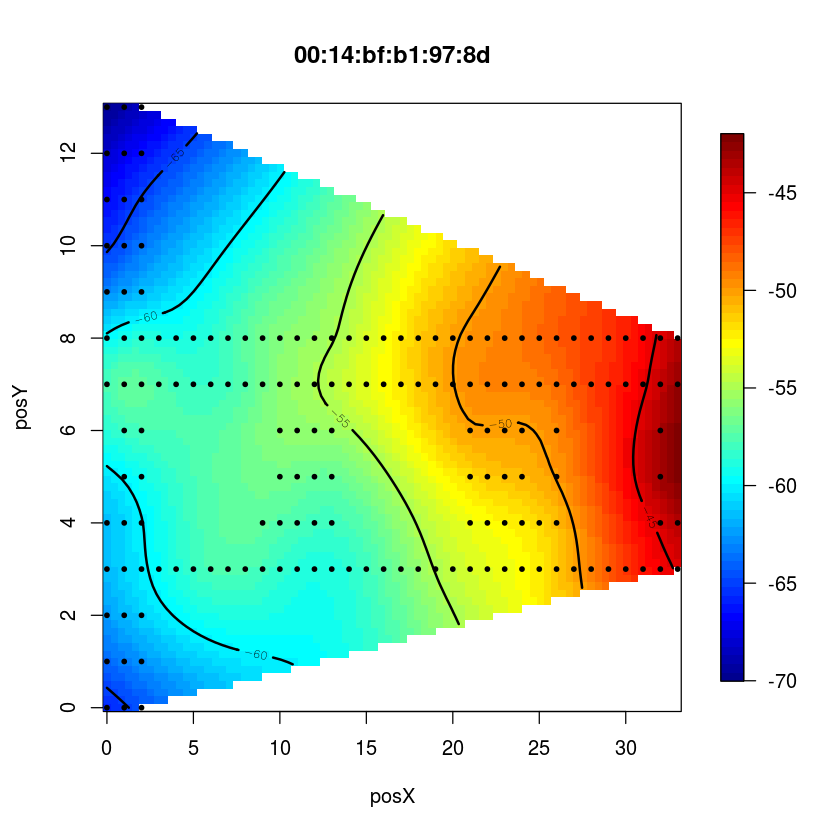

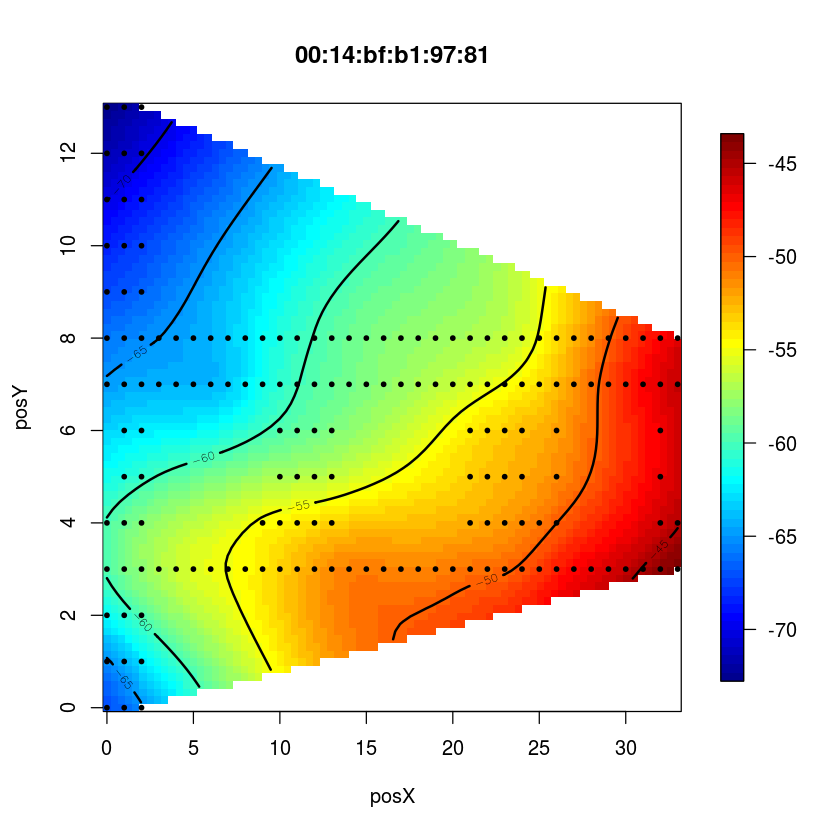

In [26]:
plotAllHeatMaps = function(){
    for (thismac in submac){
    print(mac)

    oneAPAngle = subset(offlineSummary, mac == thismac & angle == 0)

    smoothSS = Tps(oneAPAngle[, c("posX","posY")], 
               oneAPAngle$avgSignal)

    vizSmooth = predictSurface(smoothSS)

    plot.surface(vizSmooth, type = "C")

    points(oneAPAngle$posX, oneAPAngle$posY, pch=19, cex = 0.5)
    
    title(thismac)
    
    }
    
    
}

plotAllHeatMaps()


Loading required package: spam
Loading required package: dotCall64
Loading required package: grid
Spam version 2.1-2 (2017-12-21) is loaded.
Type 'help( Spam)' or 'demo( spam)' for a short introduction 
and overview of this package.
Help for individual functions is also obtained by adding the
suffix '.spam' to the function name, e.g. 'help( chol.spam)'.

Attaching package: ‘spam’

The following objects are masked from ‘package:base’:

    backsolve, forwardsolve

Loading required package: maps


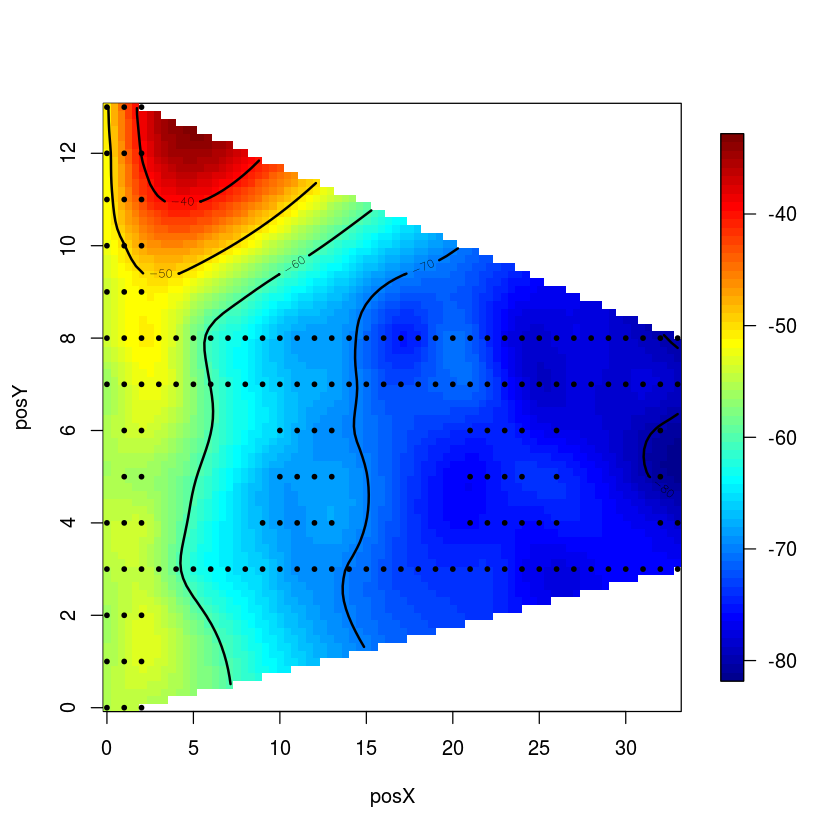

In [13]:
library(fields)

oneAPAngle = subset(offlineSummary, mac == submac[5] & angle == 0)

smoothSS = Tps(oneAPAngle[, c("posX","posY")], 
               oneAPAngle$avgSignal)

vizSmooth = predictSurface(smoothSS)

plot.surface(vizSmooth, type = "C")

points(oneAPAngle$posX, oneAPAngle$posY, pch=19, cex = 0.5)

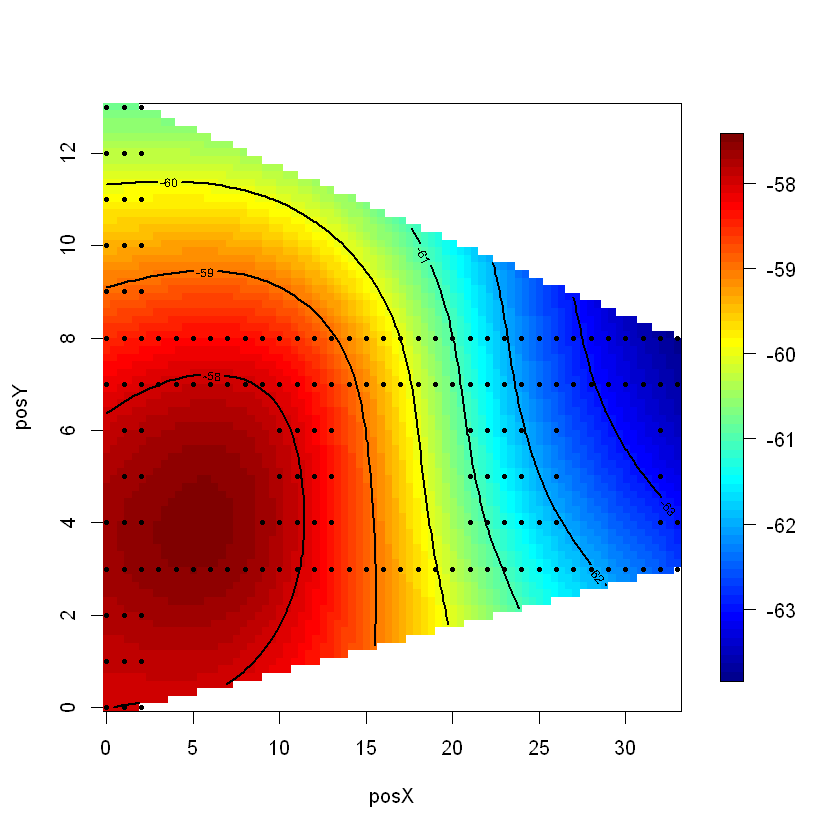

In [91]:
# overall signal strength
library(fields)

allAPAngle = subset(offlineSummary, angle == 0)

smoothSS = Tps(allAPAngle[, c("posX","posY")], 
               allAPAngle$avgSignal)

vizSmooth = predictSurface(smoothSS)

plot.surface(vizSmooth, type = "C")

points(allAPAngle$posX, allAPAngle$posY, pch=19, cex = 0.5)



In [92]:
unique(offlineSummary$mac)

[1] "00:0f:a3:39:dd:cd" "00:0f:a3:39:e1:c0" "00:14:bf:3b:c7:c6"
[4] "00:14:bf:b1:97:81" "00:14:bf:b1:97:8a" "00:14:bf:b1:97:8d"
[7] "00:14:bf:b1:97:90"

In [29]:
thismacmac = "10101"
aa = 135
paste(c(mac, "at angle", aa), sep = " ")

[1] "00:14:bf:b1:97:81" "at angle"          "135"

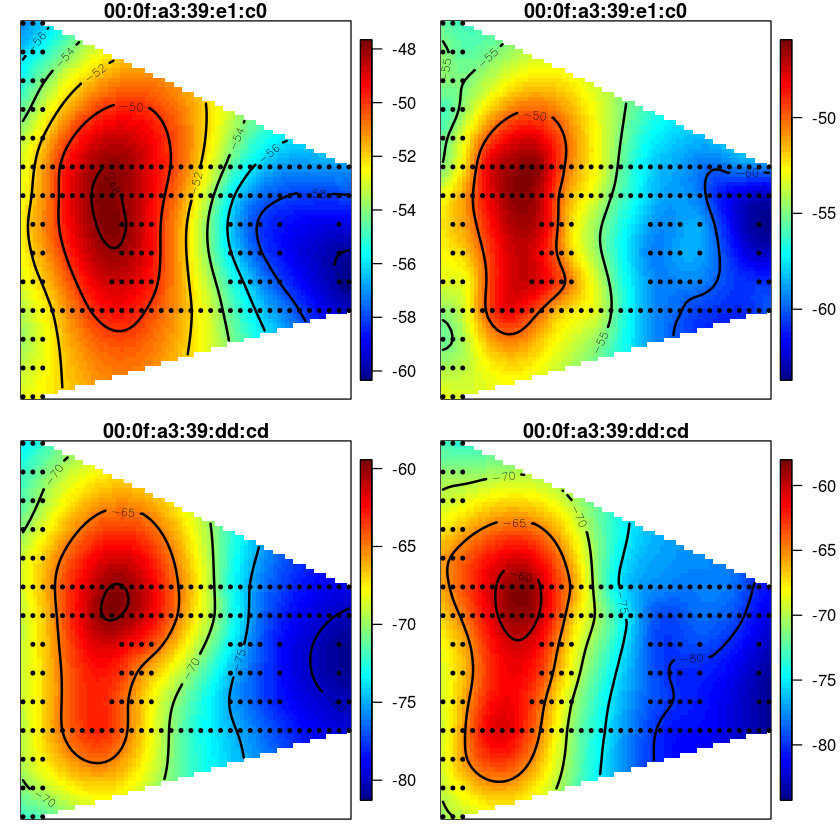

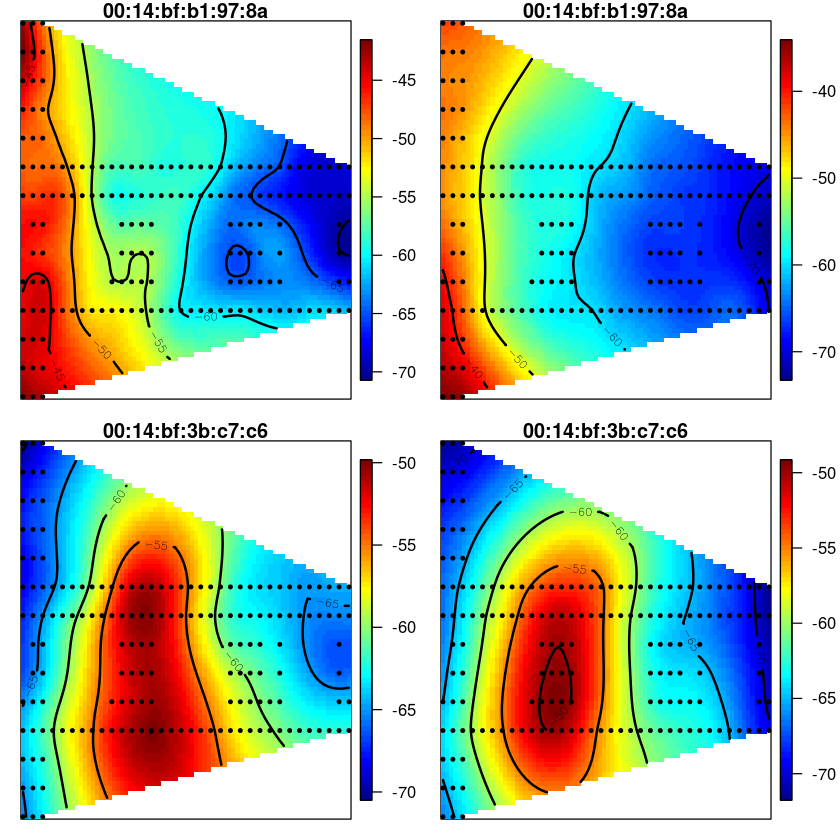

Warning message in mapply(surfaceSS, mac = submac[rep(c(1, 2, 3, 4, 5, 6, 7), each = 2)], :
“longer argument not a multiple of length of shorter”ERROR while rich displaying an object: Error in vapply(seq_along(mapped), function(i) {: values must be length 1,
 but FUN(X[[1]]) result is length 0

Traceback:
1. FUN(X[[i]], ...)
2. tryCatch(withCallingHandlers({
 .     rpr <- mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler), error = outer_handler)
3. tryCatchList(expr, classes, parentenv, handlers)
4. tryCatchOne(expr, names, parentenv, handlers[[1L]])
5. doTryCatch(return(expr), name, parentenv, handler)
6. withCallingHandlers({
 .     rpr <- mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler)
7. mime2repr[[mime]](obj)
8. repr_html.list(obj)
9. repr_list_generic(obj, "html", "\t<li>%s</li>\n", "\t<dt>$%s</d

$`00:0f:a3:39:e1:c0`
NULL

$`00:0f:a3:39:e1:c0`
NULL

$`00:0f:a3:39:dd:cd`
NULL

$`00:0f:a3:39:dd:cd`
NULL

$`00:14:bf:b1:97:8a`
NULL

$`00:14:bf:b1:97:8a`
NULL

$`00:14:bf:3b:c7:c6`
NULL

$`00:14:bf:3b:c7:c6`
NULL

$`00:14:bf:b1:97:90`
NULL

$`00:14:bf:b1:97:90`
NULL

$`00:14:bf:b1:97:8d`
NULL

$`00:14:bf:b1:97:8d`
NULL

$`00:14:bf:b1:97:81`
NULL

$`00:14:bf:b1:97:81`
NULL


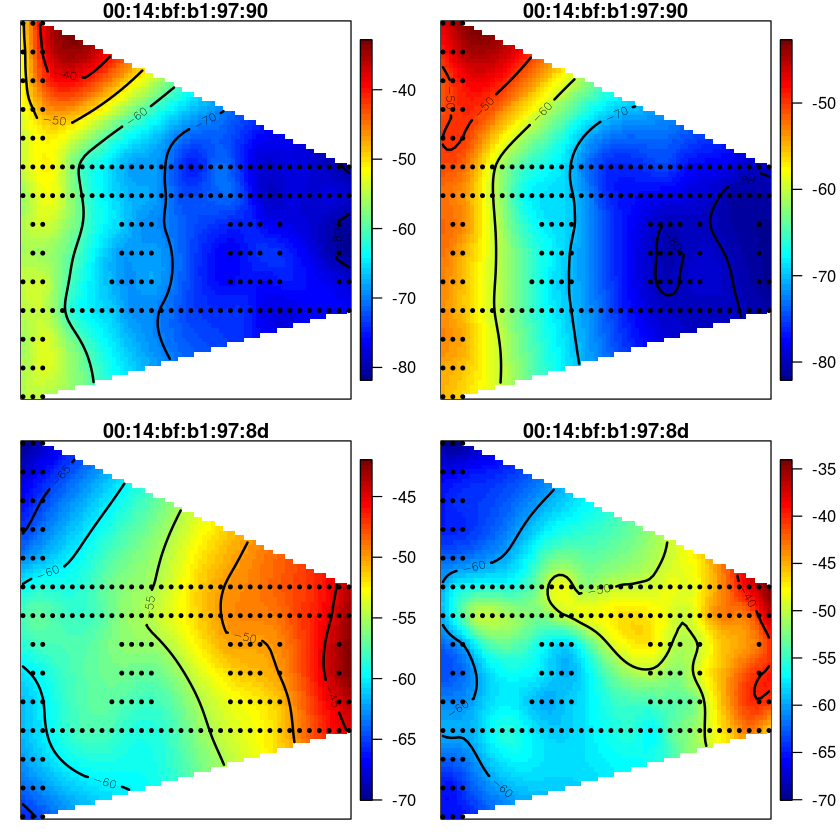

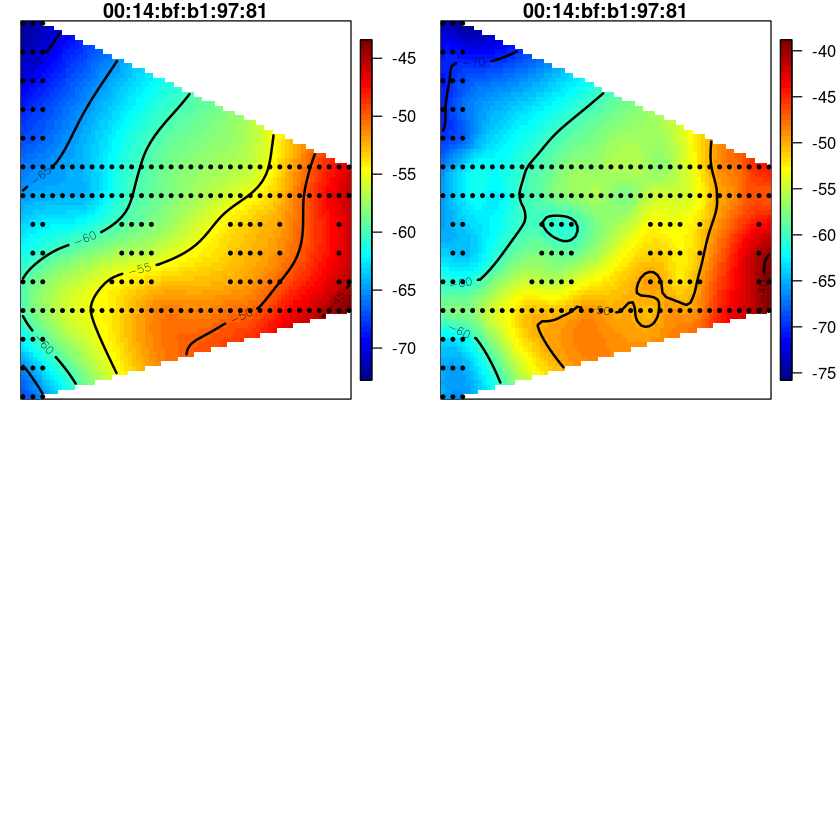

In [33]:
surfaceSS = function(data, mac, angle = 45) {
  require(fields)
  oneAPAngle = data[ data$mac == mac & data$angle == angle, ]
  smoothSS = Tps(oneAPAngle[, c("posX","posY")], 
                 oneAPAngle$avgSignal)
  vizSmooth = predictSurface(smoothSS)
  plot.surface(vizSmooth, type = "C", 
               xlab = "", ylab = "", xaxt = "n", yaxt = "n")
  points(oneAPAngle$posX, oneAPAngle$posY, pch=19, cex = 0.5)
  title(mac)
}

parCur = par(mfrow = c(2,2), mar = rep(1, 4))

mapply(surfaceSS, mac = submac[ rep(c(1,2,3,4,5,6,7), each = 2) ], 
       angle = rep(c(0, 135), 2),
       data = list(data = offlineSummary))
 
# par(parCur)

# # offlineSummary = subset(offlineSummary, mac != submac[2])

# AP = matrix( c( 7.5, 6.3, 2.5, -.8, 12.8, -2.8,  
#                 1, 14, 33.5, 9.3,  33.5, 2.8),
#             ncol = 2, byrow = TRUE,
#             dimnames = list(submac[ -2 ], c("x", "y") ))

# AP

In [35]:
submac[ rep(c(5, 1), each = 6) ]
submac

[1] "00:14:bf:b1:97:90" "00:14:bf:b1:97:90" "00:14:bf:b1:97:90"
 [4] "00:14:bf:b1:97:90" "00:14:bf:b1:97:90" "00:14:bf:b1:97:90"
 [7] "00:0f:a3:39:e1:c0" "00:0f:a3:39:e1:c0" "00:0f:a3:39:e1:c0"
[10] "00:0f:a3:39:e1:c0" "00:0f:a3:39:e1:c0" "00:0f:a3:39:e1:c0"

[1] "00:0f:a3:39:e1:c0" "00:0f:a3:39:dd:cd" "00:14:bf:b1:97:8a"
[4] "00:14:bf:3b:c7:c6" "00:14:bf:b1:97:90" "00:14:bf:b1:97:8d"
[7] "00:14:bf:b1:97:81"

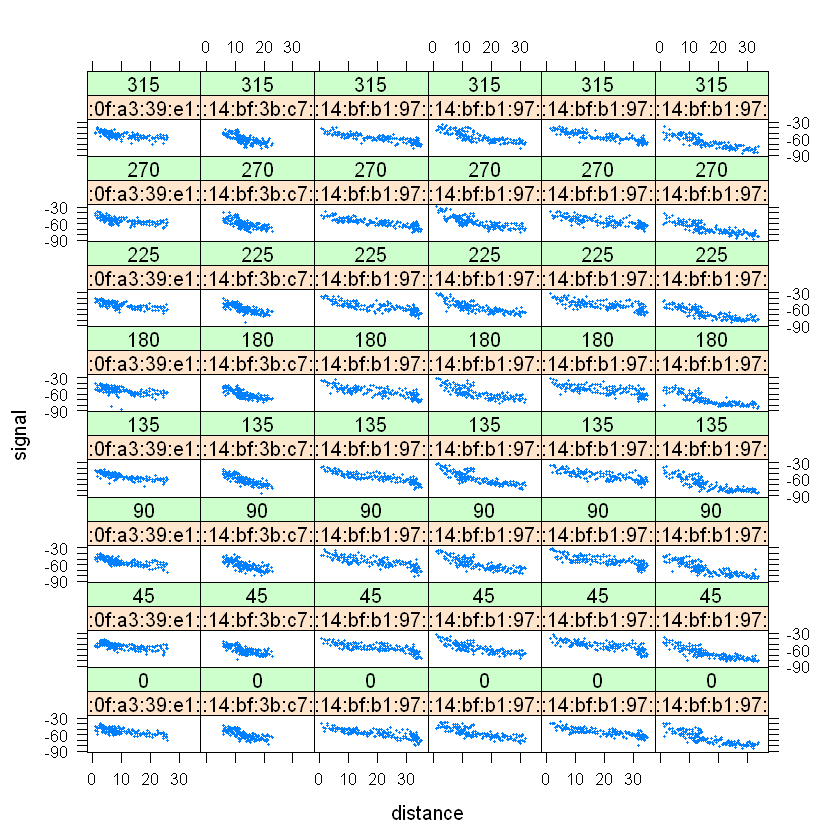

null device 
          1

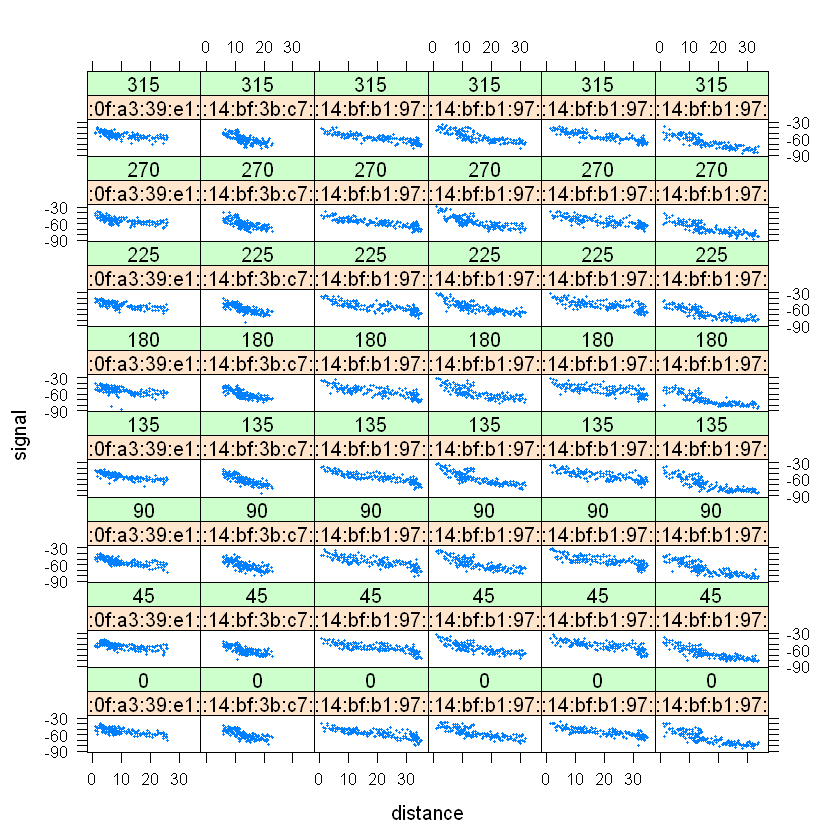

In [95]:
diffs = offlineSummary[ , c("posX", "posY")] - AP[ offlineSummary$mac, ]

offlineSummary$dist = sqrt(diffs[ , 1]^2 + diffs[ , 2]^2)

xyplot(signal ~ dist | factor(mac) + factor(angle), 
       data = offlineSummary, pch = 19, cex = 0.3,
       xlab ="distance")

#pdf(file="Geo_ScatterSignalDist.pdf", width = 7, height = 10)
oldPar = par(mar = c(3.1, 3.1, 1, 1))
library(lattice)
xyplot(signal ~ dist | factor(mac) + factor(angle), 
       data = offlineSummary, pch = 19, cex = 0.3,
       xlab ="distance")
par(oldPar)
dev.off()

macs = unique(offlineSummary$mac)

## EVERYTHING BELOW HERE IS FOR AN ANALYSIS WITH ALL MACS. I WILL MAKE SIMILAR SECTIONS FOR EACH OF THE TWO OTHER MACS THAT WE WILL INVESTIGATE.

In [40]:
onlinePath1 = 'C:/Users/casey/Dropbox/SMU_DataScience/MSDS_7333_QuantifyingTheWorld/Homework/CaseStudy1/online.final.trace.txt'
onlinePath2 =  '/home/kyle/Documents/thomaskh522@gmail.com/SMU/Quant the World/RTLS_CaseStudy/Data/online_data.txt'

online = readData(onlinePath2, subMacs = submac)

length(unique(online$posXY))

tabonlineXYA = table(online$posXY, online$angle)
tabonlineXYA[1:6, ]

keepVars = c("posXY", "posX","posY", "orientation", "angle")
byLoc = with(online, 
             by(online, list(posXY), 
                function(x) {
                  ans = x[1, keepVars]
                  avgSS = tapply(x$signal, x$mac, mean)
                  y = matrix(avgSS, nrow = 1, ncol = 7, #ncol was 6
                        dimnames = list(ans$posXY, names(avgSS)))
                  cbind(ans, y)
                }))

onlineSummary = do.call("rbind", byLoc)  



[1] 55

      
         0  45  90 135 180 225 270 315
  0-0    0   0   0 704   0   0   0   0
  0-11   0   0   0   0   0 684   0   0
  0-8  701   0   0   0   0   0   0   0
  0-9    0   0 717   0   0   0   0   0
  1-11 695   0   0   0   0   0   0   0
  1-12   0   0   0   0 691 742   0   0

In [41]:
dim(onlineSummary)

names(onlineSummary)
m = 3; angleNewObs = 230
refs = seq(0, by = 45, length  = 8)
nearestAngle = roundOrientation(angleNewObs)
  
if (m %% 2 == 1) {
  angles = seq(-45 * (m - 1) /2, 45 * (m - 1) /2, length = m)
} else {
  m = m + 1
  angles = seq(-45 * (m - 1) /2, 45 * (m - 1) /2, length = m)
  if (sign(angleNewObs - nearestAngle) > -1) 
    angles = angles[ -1 ]
  else 
    angles = angles[ -m ]
}
angles = angles + nearestAngle
angles[angles < 0] = angles[ angles < 0 ] + 360
angles[angles > 360] = angles[ angles > 360 ] - 360

[1] 55 12

[1] "posXY"             "posX"              "posY"             
 [4] "orientation"       "angle"             "00:0f:a3:39:dd:cd"
 [7] "00:0f:a3:39:e1:c0" "00:14:bf:3b:c7:c6" "00:14:bf:b1:97:81"
[10] "00:14:bf:b1:97:8a" "00:14:bf:b1:97:8d" "00:14:bf:b1:97:90"

In [43]:
offlineSubset = 
  offlineSummary[ offlineSummary$angle %in% angles, ]

reshapeSS = function(data, varSignal = "signal", 
                     keepVars = c("posXY", "posX","posY")) {
  byLocation =
    with(data, by(data, list(posXY), 
                  function(x) {
                    ans = x[1, keepVars]
                    avgSS = tapply(x[ , varSignal ], x$mac, mean)
                    y = matrix(avgSS, nrow = 1, ncol = 7, #ncol was 6
                               dimnames = list(ans$posXY,
                                               names(avgSS)))
                    cbind(ans, y)
                  }))

  newDataSS = do.call("rbind", byLocation)
  return(newDataSS)
}

trainSS = reshapeSS(offlineSubset, varSignal = "avgSignal")

In [44]:
selectTrain = function(angleNewObs, signals = NULL, m = 1){
  # m is the number of angles to keep between 1 and 5
  refs = seq(0, by = 45, length  = 8)
  nearestAngle = roundOrientation(angleNewObs)
  
  if (m %% 2 == 1) 
    angles = seq(-45 * (m - 1) /2, 45 * (m - 1) /2, length = m)
  else {
    m = m + 1
    angles = seq(-45 * (m - 1) /2, 45 * (m - 1) /2, length = m)
    if (sign(angleNewObs - nearestAngle) > -1) 
      angles = angles[ -1 ]
    else 
      angles = angles[ -m ]
  }
  angles = angles + nearestAngle
  angles[angles < 0] = angles[ angles < 0 ] + 360
  angles[angles > 360] = angles[ angles > 360 ] - 360
  angles = sort(angles) 
  
  offlineSubset = signals[ signals$angle %in% angles, ]
  reshapeSS(offlineSubset, varSignal = "avgSignal")
}

In [45]:
train130 = selectTrain(130, offlineSummary, m = 3)

head(train130)

length(train130[[1]])

findNN = function(newSignal, trainSubset) {
  diffs = apply(trainSubset[ , 4:9], 1, 
                function(x) x - newSignal)
  dists = apply(diffs, 2, function(x) sqrt(sum(x^2)) )
  closest = order(dists)
  return(trainSubset[closest, 1:3 ])
}



,posXY,posX,posY,00:0f:a3:39:dd:cd,00:0f:a3:39:e1:c0,00:14:bf:3b:c7:c6,00:14:bf:b1:97:81,00:14:bf:b1:97:8a,00:14:bf:b1:97:8d,00:14:bf:b1:97:90
0-0,0-0,0,0,-71.76555,-52.37243,-66.13039,-63.19262,-35.58063,-64.25411,-55.33780
0-1,0-1,0,1,-70.47375,-52.98182,-65.37177,-63.72941,-39.37649,-65.44867,-59.15328
0-10,0-10,0,10,-70.12946,-56.34184,-65.67238,-69.16041,-44.71545,-66.85781,-50.45502
0-11,0-11,0,11,-70.62604,-54.73420,-67.17593,-70.34538,-48.34689,-66.78383,-54.93054
0-12,0-12,0,12,-68.84840,-56.03030,-70.46493,-72.28758,-45.17264,-66.72696,-50.49886
0-13,0-13,0,13,-73.49886,-54.55152,-71.19211,-72.58496,-43.32784,-68.72616,-54.48160


[1] 166

In [46]:
predXY = function(newSignals, newAngles, trainData, 
                  numAngles = 1, k = 3){
  
  closeXY = list(length = nrow(newSignals))
  
  for (i in 1:nrow(newSignals)) {
    trainSS = selectTrain(newAngles[i], trainData, m = numAngles)
    closeXY[[i]] = 
      findNN(newSignal = as.numeric(newSignals[i, ]), trainSS)
  }

  estXY = lapply(closeXY, 
                 function(x) sapply(x[ , 2:3], 
                                    function(x) mean(x[1:k])))
  estXY = do.call("rbind", estXY)
  return(estXY)
}
estXYk3 = predXY(newSignals = onlineSummary[ , 6:11], 
                 newAngles = onlineSummary[ , 4], 
                 offlineSummary, numAngles = 3, k = 3)

estXYk1 = predXY(newSignals = onlineSummary[ , 6:11], 
                 newAngles = onlineSummary[ , 4], 
                 offlineSummary, numAngles = 3, k = 1)



In [47]:
floorErrorMap = function(estXY, actualXY, trainPoints = NULL, AP = NULL){
  
    plot(0, 0, xlim = c(0, 35), ylim = c(-3, 15), type = "n",
         xlab = "", ylab = "", axes = FALSE)
    box()
    if ( !is.null(AP) ) points(AP, pch = 15)
    if ( !is.null(trainPoints) )
      points(trainPoints, pch = 19, col="grey", cex = 0.6)
    
    points(x = actualXY[, 1], y = actualXY[, 2], 
           pch = 19, cex = 0.8 )
    points(x = estXY[, 1], y = estXY[, 2], 
           pch = 8, cex = 0.8 )
    segments(x0 = estXY[, 1], y0 = estXY[, 2],
             x1 = actualXY[, 1], y1 = actualXY[ , 2],
             lwd = 2, col = "red")
}

trainPoints = offlineSummary[ offlineSummary$angle == 0 & 
                              offlineSummary$mac == "00:0f:a3:39:e1:c0" ,
                        c("posX", "posY")]

null device 
          1

null device 
          1

[1] 473.0000 261.2222

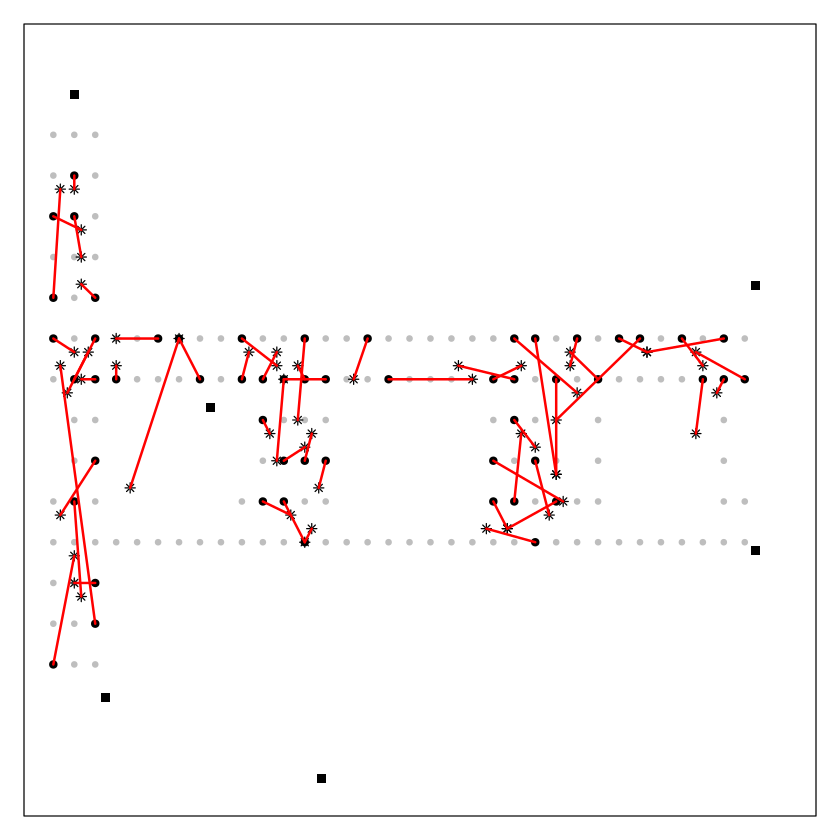

In [48]:
#pdf(file="GEO_FloorPlanK3Errors.pdf", width = 10, height = 7)
oldPar = par(mar = c(1, 1, 1, 1))
floorErrorMap(estXYk3, onlineSummary[ , c("posX","posY")], 
              trainPoints = trainPoints, AP = AP)
par(oldPar)
dev.off()

#pdf(file="GEO_FloorPlanK1Errors.pdf", width = 10, height = 7)
oldPar = par(mar = c(1, 1, 1, 1))
floorErrorMap(estXYk1, onlineSummary[ , c("posX","posY")], 
              trainPoints = trainPoints, AP = AP)
par(oldPar)
dev.off()

calcError = 
function(estXY, actualXY) 
   sum( rowSums( (estXY - actualXY)^2) )

actualXY = onlineSummary[ , c("posX", "posY")]
sapply(list(estXYk1, estXYk3), calcError, actualXY)

In [49]:
calcError = 
function(estXY, actualXY) 
   sum( rowSums( (estXY - actualXY)^2) )

actualXY = onlineSummary[ , c("posX", "posY")]
sapply(list(estXYk1, estXYk3), calcError, actualXY)

[1] 473.0000 261.2222

In [52]:
v = 11
# permuteLocs = sample(unique(offlineSummary$posXY))
permuteLocs = matrix(permuteLocs, ncol = v, 
                     nrow = floor(length(permuteLocs)/v))

onlineFold = subset(offlineSummary, posXY %in% permuteLocs[ , 1])

reshapeSS = function(data, varSignal = "signal", 
                     keepVars = c("posXY", "posX","posY"),
                     sampleAngle = FALSE, 
                     refs = seq(0, 315, by = 45)) {
  byLocation =
    with(data, by(data, list(posXY), 
                  function(x) {
                    if (sampleAngle) {
                      x = x[x$angle == sample(refs, size = 1), ]}
                    ans = x[1, keepVars]
                    avgSS = tapply(x[ , varSignal ], x$mac, mean)
                    y = matrix(avgSS, nrow = 1, ncol = 7, #ncol was 6
                               dimnames = list(ans$posXY,
                                               names(avgSS)))
                    cbind(ans, y)
                  }))

  newDataSS = do.call("rbind", byLocation)
  return(newDataSS)
}

In [53]:
# offline = offline[ offline$mac != "00:0f:a3:39:dd:cd", ]

keepVars = c("posXY", "posX","posY", "orientation", "angle")

onlineCVSummary = reshapeSS(offline, keepVars = keepVars, 
                            sampleAngle = TRUE)

onlineFold = subset(onlineCVSummary, 
                    posXY %in% permuteLocs[ , 1])

offlineFold = subset(offlineSummary,
                     posXY %in% permuteLocs[ , -1])

estFold = predXY(newSignals = onlineFold[ , 6:11], 
                 newAngles = onlineFold[ , 4], 
                 offlineFold, numAngles = 3, k = 3)

In [54]:
onlineCVSummary

,posXY,posX,posY,orientation,angle,00:0f:a3:39:dd:cd,00:0f:a3:39:e1:c0,00:14:bf:3b:c7:c6,00:14:bf:b1:97:81,00:14:bf:b1:97:8a,00:14:bf:b1:97:8d,00:14:bf:b1:97:90
0-0,0-0,0,0,180.3,180,-71.93694,-55.02727,-68.31818,-62.42857,-33.92381,-66.00000,-56.49495
0-1,0-1,0,1,315.3,315,-73.03604,-54.58182,-67.58763,-71.98795,-37.77451,-67.33333,-58.61957
0-10,0-10,0,10,270.5,270,-68.85714,-57.15455,-63.26744,-62.86905,-41.34043,-64.16667,-57.80645
0-11,0-11,0,11,225.1,225,-69.59459,-50.90826,-67.34409,-67.27059,-50.63636,-67.57955,-56.27885
0-12,0-12,0,12,135.0,135,-68.57273,-52.52727,-68.90816,-70.32222,-43.11009,-63.73494,-48.99000
0-13,0-13,0,13,225.0,225,-73.65766,-56.16364,-71.08511,-70.87912,-44.85577,-69.20225,-57.28713
0-2,0-2,0,2,135.2,135,-72.93805,-55.76577,-62.24211,-64.96471,-39.13084,-61.11364,-50.42268
0-3,0-3,0,3,0.2,0,-69.09649,-55.53636,-62.90526,-56.68817,-49.96040,-59.29412,-55.37755
0-4,0-4,0,4,89.4,90,-68.64602,-51.34545,-62.65263,-60.88298,-40.88000,-62.88764,-50.16162
0-7,0-7,0,7,225.9,225,-67.22321,-53.31818,-62.71264,-63.89552,-43.83333,-52.07447,-59.40000


In [55]:
permuteLocs

7-3,11-7,1-12,2-3,31-3,12-8,1-13,1-11,28-7,5-7,0-12
30-7,17-3,9-4,0-3,19-8,26-6,13-5,24-3,13-3,25-8,26-5
33-3,10-5,33-8,18-3,5-3,26-3,28-3,0-13,24-4,22-6,2-7
27-3,1-10,21-5,0-7,7-7,25-7,0-10,2-12,24-8,9-8,11-5
12-6,1-1,2-1,0-11,33-7,10-3,4-8,1-5,3-8,22-7,16-7
0-8,26-7,0-1,14-3,11-8,8-3,10-6,9-3,24-5,30-3,4-7
23-6,20-3,13-4,22-8,0-2,16-8,30-8,7-8,12-5,26-4,9-7
31-8,10-8,12-7,2-2,29-8,15-3,12-3,6-7,23-7,2-9,33-4
32-5,22-3,15-7,3-7,22-5,24-6,4-3,18-7,21-3,2-6,17-8
26-8,1-3,29-7,2-10,11-3,14-7,21-4,20-8,19-3,1-0,18-8
24-7,6-3,12-4,32-6,13-7,11-4,23-8,23-5,2-4,8-7,32-4


In [56]:
actualFold = onlineFold[ , c("posX", "posY")]
calcError(estFold, actualFold)

K = 20
err = rep(0, K)

for (j in 1:v) {
  onlineFold = subset(onlineCVSummary, 
                      posXY %in% permuteLocs[ , j])
  offlineFold = subset(offlineSummary,
                       posXY %in% permuteLocs[ , -j])
  actualFold = onlineFold[ , c("posX", "posY")]
  
  for (k in 1:K) {
    estFold = predXY(newSignals = onlineFold[ , 6:11],
                     newAngles = onlineFold[ , 4], 
                     offlineFold, numAngles = 3, k = k)
    err[k] = err[k] + calcError(estFold, actualFold)
  }
}

[1] 171.4444

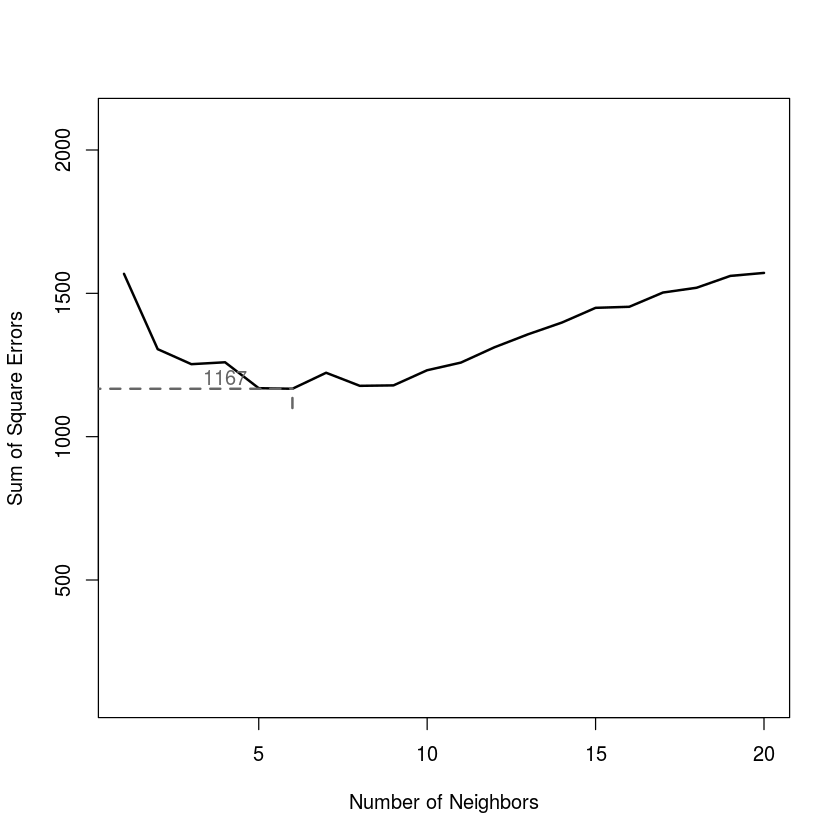

In [57]:
#pdf(file = "Geo_CVChoiceOfK.pdf", width = 10, height = 6)
#oldPar = par(mar = c(4, 3, 1, 1))
plot(y = err, x = (1:K),  type = "l", lwd= 2,
     ylim = c(100, 2100),
     xlab = "Number of Neighbors",
     ylab = "Sum of Square Errors")

rmseMin = min(err)
kMin = which(err == rmseMin)[1]
segments(x0 = 0, x1 = kMin, y0 = rmseMin, col = gray(0.4), 
         lty = 2, lwd = 2)
segments(x0 = kMin, x1 = kMin, y0 = 1100,  y1 = rmseMin, 
         col = grey(0.4), lty = 2, lwd = 2)
text(x = kMin - 2, y = rmseMin + 40, 
     label = as.character(round(rmseMin)), col = grey(0.4))
#par(oldPar)
#dev.off()

In [58]:
#mtext(kMin, side = 1, line = 1, at = kMin, col = grey(0.4))


estXYk6 = predXY(newSignals = onlineSummary[ , 6:11], 
                 newAngles = onlineSummary[ , 4], 
                 offlineSummary, numAngles = 3, k = 6)

calcError(estXYk6, actualXY)

[1] 247.6389

In [59]:
predXY = function(newSignals, newAngles, trainData, 
                  numAngles = 1, k = 3){
  
  closeXY = list(length = nrow(newSignals))
  
  for (i in 1:nrow(newSignals)) {
    trainSS = selectTrain(newAngles[i], trainData, m = numAngles)
    closeXY[[i]] = findNN(newSignal = as.numeric(newSignals[i, ]),
                           trainSS)
  }

  estXY = lapply(closeXY, function(x)
                            sapply(x[ , 2:3], 
                                    function(x) mean(x[1:k])))
  estXY = do.call("rbind", estXY)
  return(estXY)
}

In [60]:
findWNN = function(newSignal, trainSubset) {
  diffs = apply(trainSubset[ , 4:9], 1,
                function(x) abs(x - newSignal))
  dists = apply(diffs, 2, function(x) (1/x)/sum(1/x) )
  closest = order(dists)
  return(trainSubset[closest, 1:3 ])
}

In [61]:
findNN = function(newSignal, trainSubset) {
  diffs = apply(trainSubset[ , 4:9], 1, 
                function(x) x - newSignal)
  dists = apply(diffs, 2, function(x) sqrt(sum(x^2)) )
  trainSubset$dist=dists
  closest = order(dists)
  return(trainSubset[closest, 1:4 ])}

## EVERYTHING BELOW HERE IS FOR MAC 00:0f:a3:39:e1:c0

## EVERYTHING BELOW HERE IS FOR MAC 00:0f:a3:39:dd:cd

In [ ]:
dists[order(dists)]

In [ ]:
1/(1/6.99+1/9.06+1/10.7)

In [ ]:
2.88/6.99

In [ ]:
2.88/9.06

In [ ]:
a/d

In [ ]:
function(x,y)